# Find distance to an object

## Estimating f number

In order to find the f number of our camera, we are going to use 2 methods:
- The camera calibration tutorial from OpenCV
- The estimation of the f number using a reference object

### Using camera calibration

To do this, we are going to run the code provided by the tutorial at https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html. 
Before running this tutorial different photos of a chess board pattern were token. Each square of the pattern has a length of 18 mm. So we edited the code to include it.

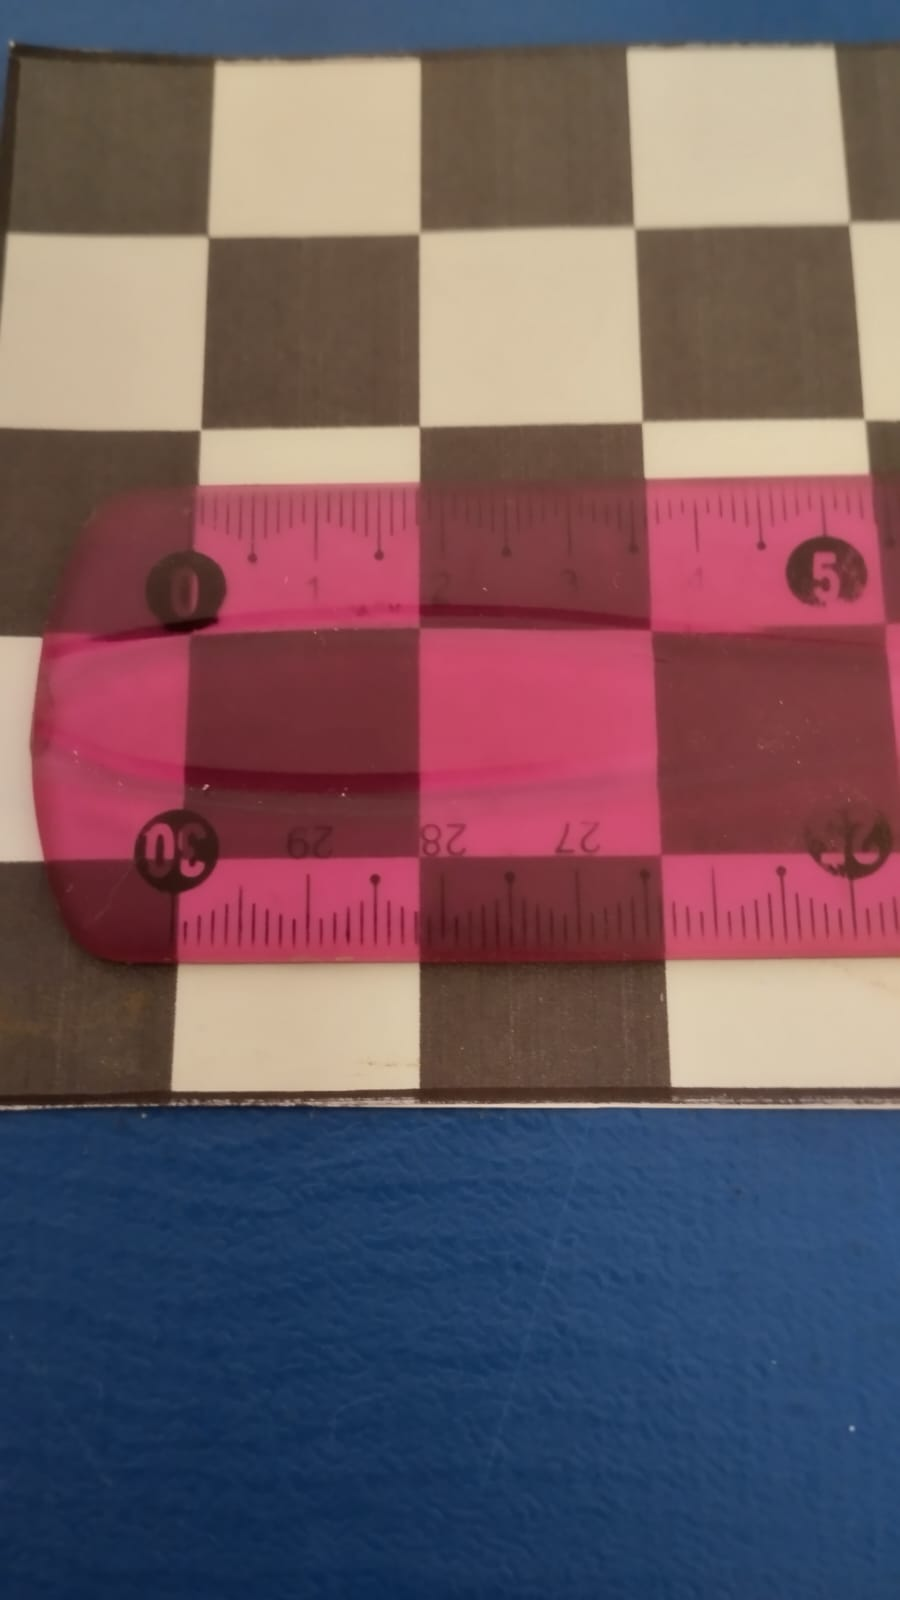

In [4]:
# This code is just for show the chess board pattern
from IPython.display import Image
Image(filename="18mm.png", width=250)

In [29]:
import numpy as np
import cv2 as cv
import glob
import pickle



################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (3,3)
frameSize = (54,54)



# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

size_of_chessboard_squares_mm = 18
objp = objp * size_of_chessboard_squares_mm


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


images = glob.glob('images/*.png')
print(len(images))

for image in images:

    img = cv.imread(image)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)
    print(ret, corners)

    # If found, add object points, image points (after refining them)
    if ret == True:
        print(image)
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv.drawChessboardCorners(img, chessboardSize, corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(1000)


cv.destroyAllWindows()




############## CALIBRATION #######################################################

ret, cameraMatrix, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, frameSize, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
pickle.dump((cameraMatrix, dist), open( "calibration.pkl", "wb" ))
pickle.dump(cameraMatrix, open( "cameraMatrix.pkl", "wb" ))
pickle.dump(dist, open( "dist.pkl", "wb" ))


############## UNDISTORTION #####################################################

img = cv.imread('images/img1.png')
h,  w = img.shape[:2]
newCameraMatrix, roi = cv.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))



# Undistort
dst = cv.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

#crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('caliResult1.png', dst)



# Undistort with Remapping
mapx, mapy = cv.initUndistortRectifyMap(cameraMatrix, dist, None, newCameraMatrix, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

#crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('caliResult2.png', dst)

focal_length_x = cameraMatrix[0, 0]
print("Focal Length in x-axis: {:.2f}".format(focal_length_x))



# Reprojection Error
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )


4
True [[[831.49744 260.336  ]]

 [[875.4991  271.15048]]

 [[920.75104 278.22977]]

 [[829.      311.     ]]

 [[874.5     319.     ]]

 [[918.53394 327.59097]]

 [[825.3095  362.21912]]

 [[871.40173 369.48828]]

 [[914.56476 375.9178 ]]]
images/img4.png
True [[[604.8439  267.21335]]

 [[654.6817  266.65567]]

 [[704.83875 264.45102]]

 [[602.4836  315.93906]]

 [[652.9052  316.2875 ]]

 [[703.97687 316.5559 ]]

 [[600.0033  365.97217]]

 [[650.76215 366.61914]]

 [[703.02185 367.41327]]]
images/img7.png
False None
True [[[632.37054 258.29602]]

 [[685.8649  261.2347 ]]

 [[740.03    263.66998]]

 [[631.1619  309.48483]]

 [[685.7968  315.04285]]

 [[738.9249  317.53976]]

 [[628.3975  365.71082]]

 [[683.5     367.5    ]]

 [[738.6948  369.8997 ]]]
images/img15.png
Focal Length in x-axis: 4048.03
total error: 0.07921716954463931


According to the calibration the focal length in x-axis is 4048.03

### Using a reference object

We are going to use a photo as a reference object. We used the cvzone package in order to identify the face and use the distance between the eyes as a reference object. After writting the code, we identify the eyes and measure the distance between them. Below the code a photograph is shown. In the photo it can be seen that the distance between the eyes of the picture of reference is 35 mm. Also, the distance between the camera and the reference objet is 345 mm. So we use these measurements to estimae the f number.

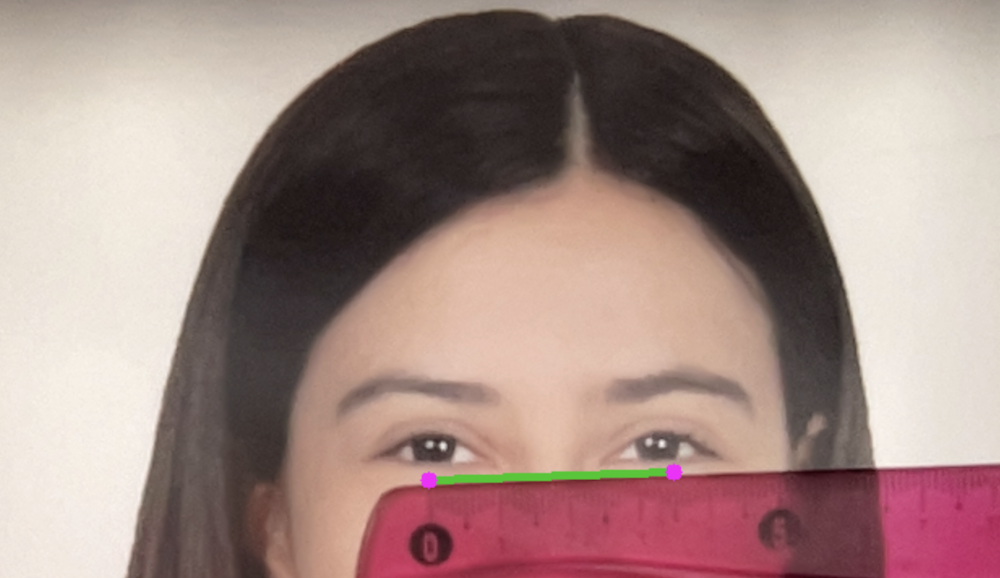

In [5]:
# This code is just for show the distance of the reference object
from IPython.display import Image
Image(filename="dist_eyes.png", width=250)

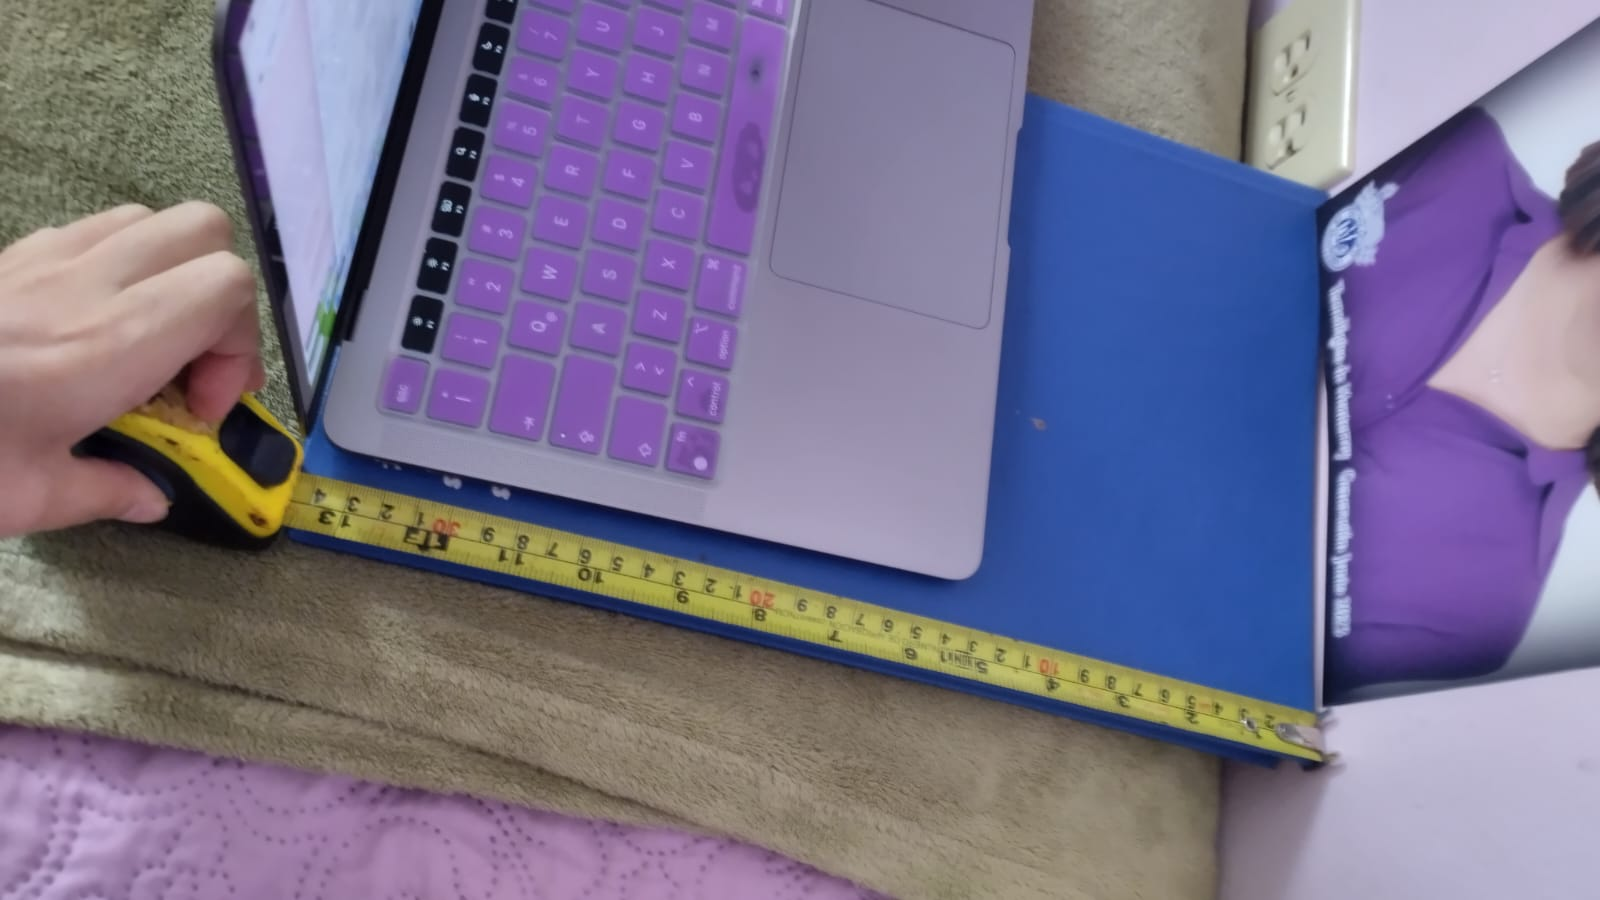

In [7]:
# This code is just for show the distance between the reference object and the camera
from IPython.display import Image
Image(filename="dist_obj_camera.jpeg", width=400)

import cv2
import cvzone
from cvzone.FaceMeshModule import FaceMeshDetector

cap = cv2.VideoCapture(0)
detector = FaceMeshDetector(maxFaces=1)

while True:
    success, img = cap.read()
    img, faces = detector.findFaceMesh(img, draw=False)

    if faces:
        face = faces[0]
        pointLeft = face[145]
        pointRight = face[374]
        # Drawing
        cv2.line(img, pointLeft, pointRight, (0, 200, 0), 3)
        cv2.circle(img, pointLeft, 5, (255, 0, 255), cv2.FILLED)
        cv2.circle(img, pointRight, 5, (255, 0, 255), cv2.FILLED)

        #Find the distance in pixels between the two
        w, _ = detector.findDistance(pointLeft, pointRight)
        # W is in mm
        W = 35
    

        # Finding the f number
        d = 345
        f = (w*d)/W
        print(f)



    cv2.imshow("Image", img)
    cv2.waitKey(1)

For running the previous script as it uses a video, we run it outside this jupyter notebook. The result of the estimation of the f number is 897.48.

Now using the f number, we can measure the distance between the photo and the camera just by adding the following lines into the coditional of the previous code.

import cv2
import cvzone
from cvzone.FaceMeshModule import FaceMeshDetector

cap = cv2.VideoCapture(0)
detector = FaceMeshDetector(maxFaces=1)

while True:
    success, img = cap.read()
    img, faces = detector.findFaceMesh(img, draw=False)

    if faces:
        face = faces[0]
        pointLeft = face[145]
        pointRight = face[374]
        
        cv2.line(img, pointLeft, pointRight, (0, 200, 0), 3)
        cv2.circle(img, pointLeft, 3, (255, 0, 255), cv2.FILLED)
        cv2.circle(img, pointRight, 3, (255, 0, 255), cv2.FILLED)

        #Find the distance in pixels between the two points (the eyes)
        w, _ = detector.findDistance(pointLeft, pointRight)
        #print(w)
        #W is in mm
        W = 35 

    

        # Find the f number
        #distance is in mm
        #d = 345
        #f = (w*d)/W
        #print(f)

        # calculate the distance
        f = 897.48
        d = (W * f) / w

        cvzone.putTextRect(img, f'Distance: {int(d)}mm',
                          (face[10][0] - 100, face[10][1] - 50),
                           scale=2)
        

    cv2.imshow("Image", img)
    cv2.waitKey(1)

### Use the estimate f number to measure the distance.

We are going to test the previous code using first the same reference object at diferent distances (because we already know the width of the object and also we are measuring the pixels already using the code)

#### First measurement

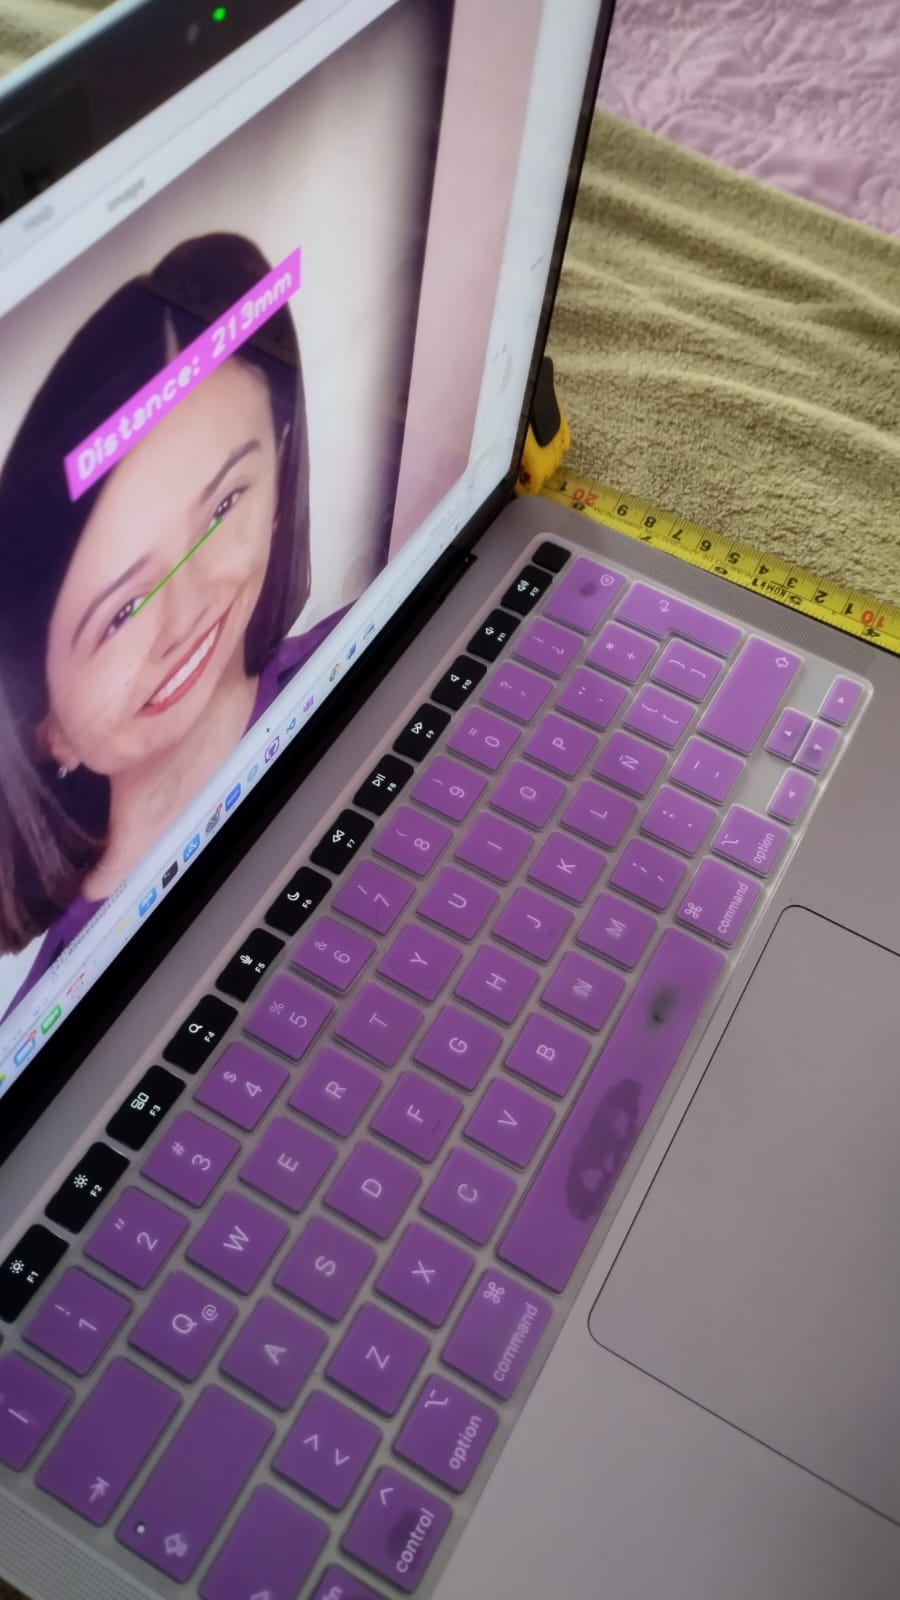

In [9]:
# This code is just for show the distance between the reference object and the camera in the 1st measurement
from IPython.display import Image
Image(filename="first.jpeg", width=300)

As a first measure the code returns a distance of 213 mm, while the true distance is 215 mm.

#### Second measurement

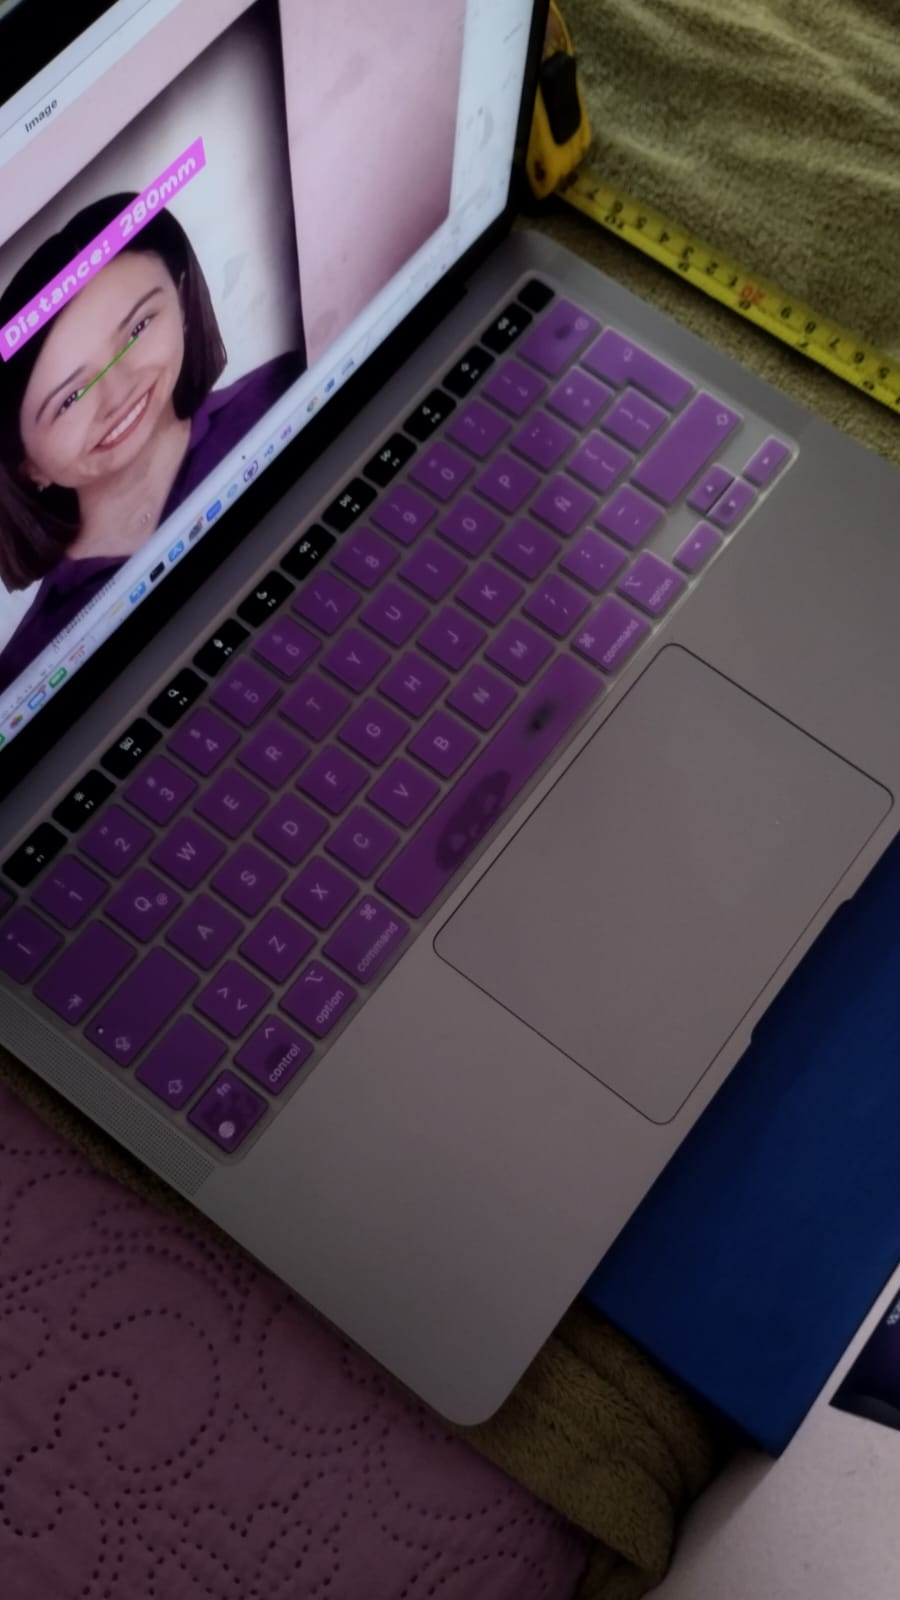

In [10]:
# This code is just for show the distance between the reference object and the camera in the 12nd measurement
from IPython.display import Image
Image(filename="second.jpeg", width=300)

During the 2nd measurement the code returns a distance of 280 mm, while the true distance was of 282 mm.

#### Third measurement

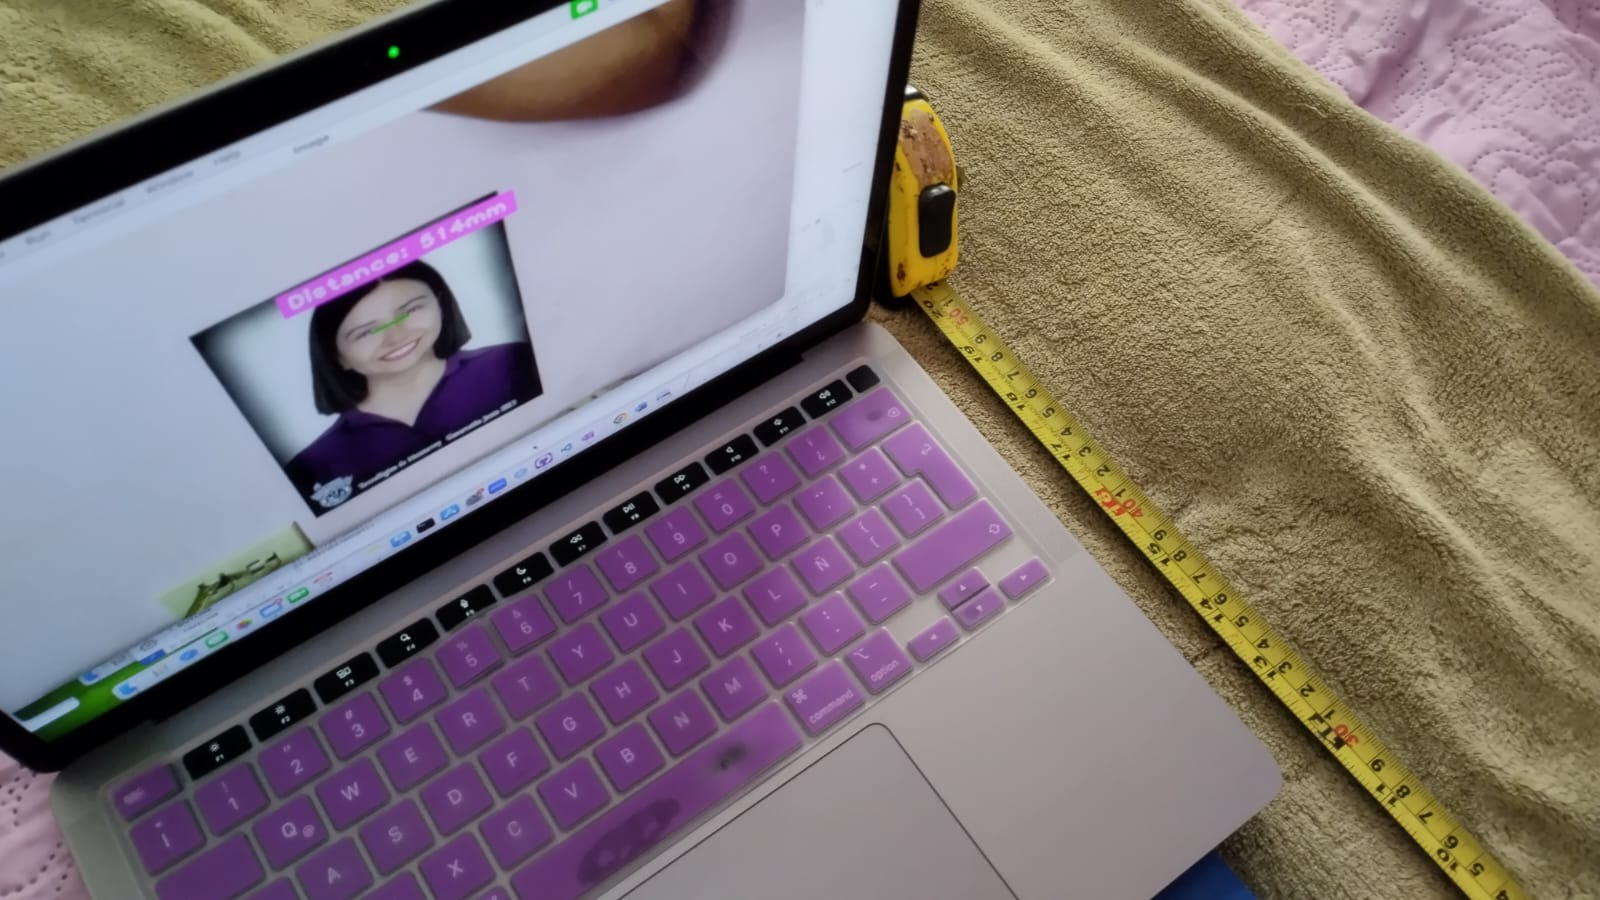

In [12]:
# This code is just for show the distance between the reference object and the camera in the 3rd measurement
from IPython.display import Image
Image(filename="third.jpeg", width=450)

For this measurement the code returns a distance equals to 514 mm, and the true distance was 519 mm.

#### Error

In [16]:
import numpy as np

measured_values = np.array([514, 280, 213])
real_values = np.array([519, 282, 215])
errors = measured_values - real_values

# Calculate MAE
mae = np.mean(np.abs(errors))

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")

Mean Absolute Error (MAE): 3.00 mm


### Use the estimate f number to measure the distance to a second reference object.

To do this, we are going to use the same photograph, but we are going to use as a reference the edge of the photograph (with a width of 201 mm). For this case we are going to use the screenshot tool to measure the pixels of the photos. Then, we are going to calculate manually the distance using the formula d = (W * f) / w.

#### First measurement

For the first measurement the real distance between the camera and the photograph was 342 mm. The width of the photograph was 574 px. 

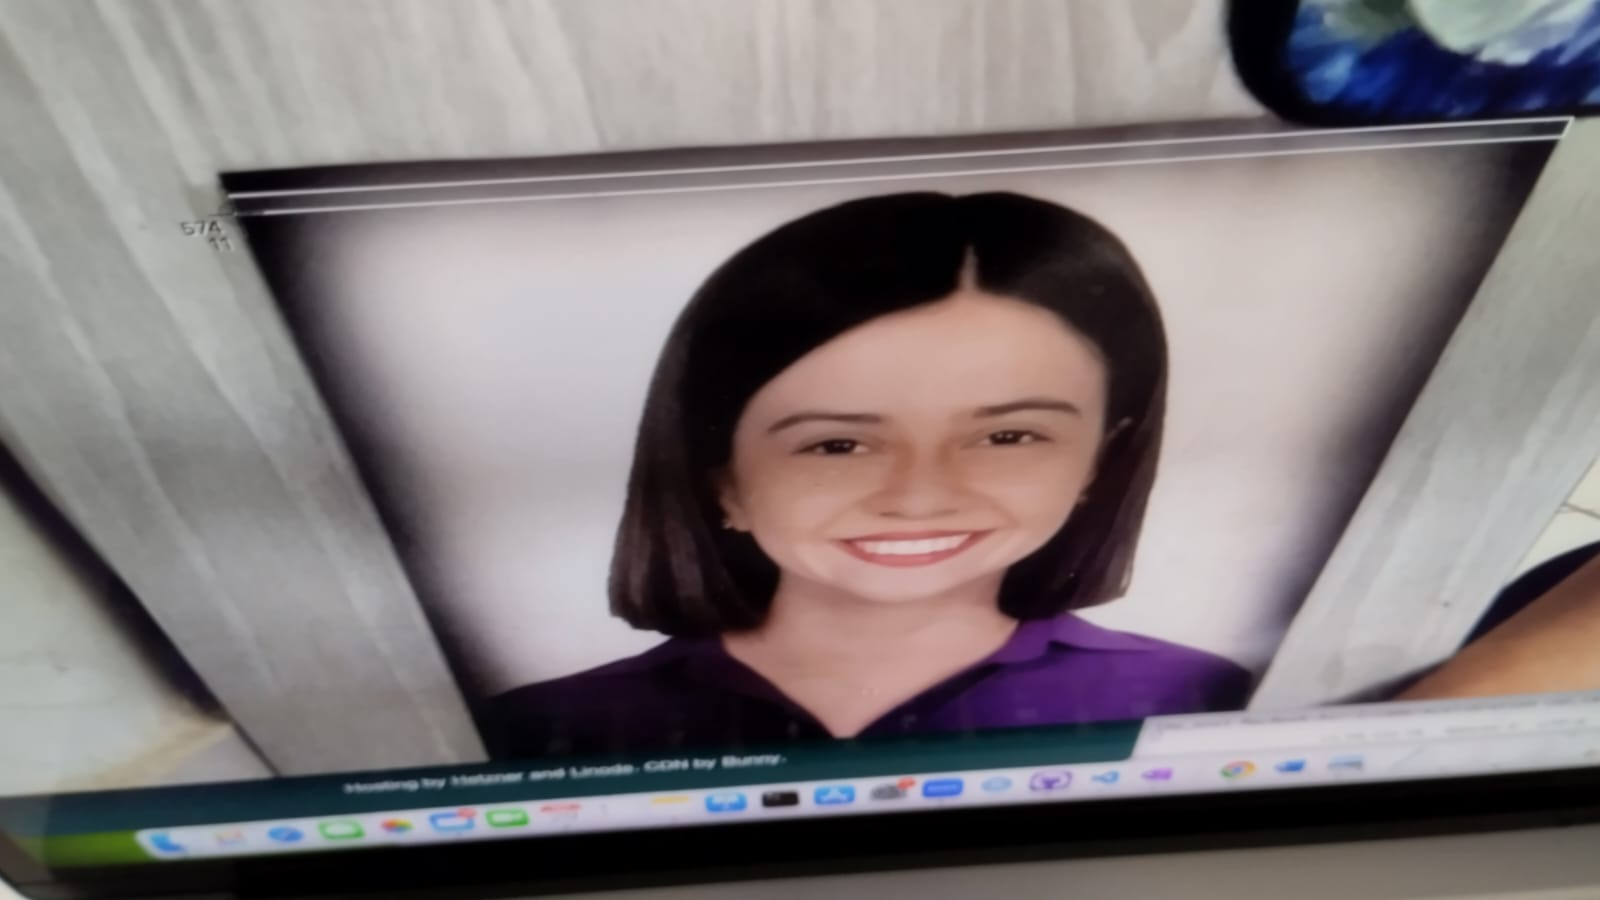

In [27]:
# This code is just for show the distance (pixels)
from IPython.display import Image
Image(filename="574.jpeg", width=450)

In [21]:
f = 897.48
W = 228 # mm 
w = 574 #pixeles
d = (W * f) / w
print(d, "mm") 

357.42844599303135 mm


The real one was 342 mm and the code returns 357.42 mm

#### Second measurement

For the second measurement the real distance between the camera and the photograph was 747 mm. The width of the photograph was 263 px. 

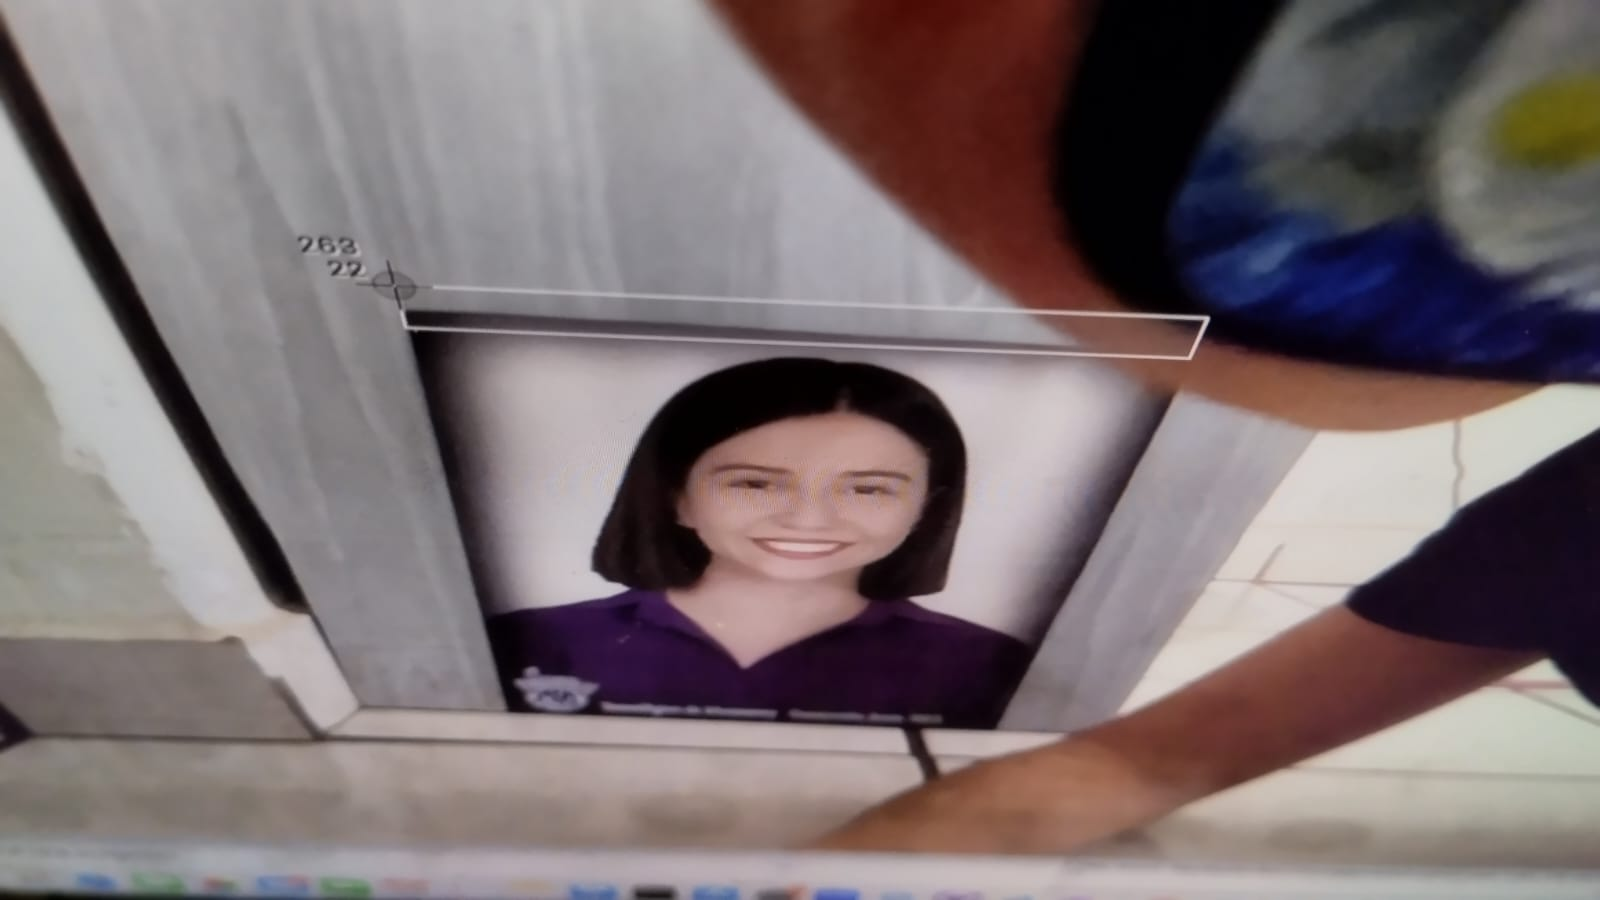

In [26]:
# This code is just for show the distance (pixels)
from IPython.display import Image
Image(filename="263.jpeg", width=450)

In [22]:
f = 897.48
W = 228 # mm 
w = 263 #pixeles
d = (W * f) / w
print(d, "mm") 

778.0434980988593 mm


#### Third measurement

For the first measurement the real distance between the camera and the photograph was 215 mm. The width of the photograph was 871 px. 

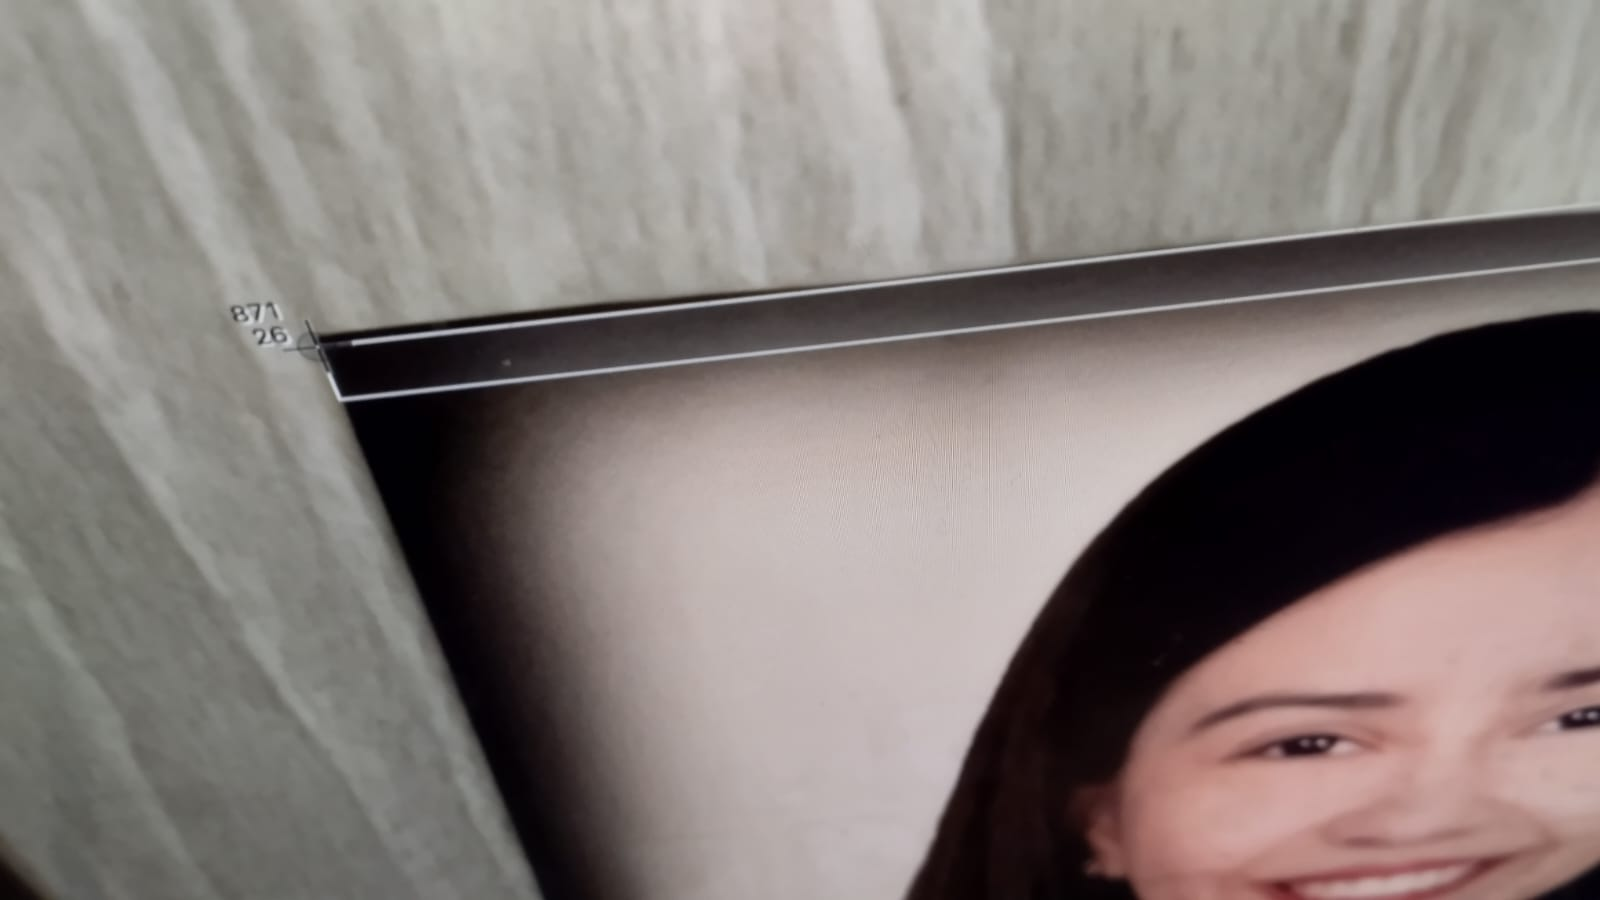

In [28]:
# This code is just for show the distance (pixels)
from IPython.display import Image
Image(filename="871.jpeg", width=450)

In [23]:
f = 897.48
W = 228 # mm 
w = 871 #pixeles
d = (W * f) / w
print(d, "mm") 

234.93161882893227 mm


### Error

In [24]:
measured_values = np.array([357.42, 778.04, 234.93])
real_values = np.array([342, 747, 215])
errors = measured_values - real_values

# Calculate MAE
mae = np.mean(np.abs(errors))

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")

Mean Absolute Error (MAE): 22.13 mm


As we can see, the error is bigger when using a second reference object. This could be because when performing pixel measurements manually there is an even greater range of error than when detected by the same code given two fixed points.